In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

SEED = 42
IMAGE_SIZE = 160   # eğitimde kullandığın değer
BATCH_SIZE = 4

DATASET_DIR = Path("Fish_Dataset")

In [4]:
filepaths = list(DATASET_DIR.glob("**/*.png")) \
          + list(DATASET_DIR.glob("**/*.jpg")) \
          + list(DATASET_DIR.glob("**/*.jpeg"))

labels = [p.parent.name for p in filepaths]

image_df = pd.DataFrame({
    "Filepath": [str(p) for p in filepaths],
    "Label": labels
})

image_df["Label"] = image_df["Label"].astype(str)

# GT filtre
image_df = image_df[~image_df["Label"].str.endswith("GT", na=False)].reset_index(drop=True)

print("Toplam veri:", len(image_df))

Toplam veri: 9000


In [5]:
_, test_df = train_test_split(
    image_df,
    test_size=0.2,
    stratify=image_df["Label"],
    random_state=SEED
)

print("Test veri sayısı:", len(test_df))

Test veri sayısı: 1800


In [6]:
classes = sorted(test_df["Label"].unique())

test_gen = ImageDataGenerator()

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    classes=classes,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1800 validated image filenames belonging to 9 classes.


In [7]:
model = load_model("outputs/20260102_202132/aug/model/best_model.keras")
# veya no_aug:
# model = load_model("outputs/20260102_191146/no_aug/model/best_model.keras")

y_prob = model.predict(test_data)
y_pred = np.argmax(y_prob, axis=1)

y_true = test_data.classes

idx2label = {v:k for k,v in test_data.class_indices.items()}
target_names = [idx2label[i] for i in range(len(idx2label))]

print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

450/450 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      0.82      0.90       200
   Gilt-Head Bream       0.99      0.79      0.88       200
   Hourse Mackerel       0.94      0.99      0.97       200
        Red Mullet       1.00      0.94      0.97       200
     Red Sea Bream       0.88      1.00      0.94       200
          Sea Bass       0.70      0.99      0.82       200
            Shrimp       1.00      0.98      0.99       200
Striped Red Mullet       0.94      0.94      0.94       200
             Trout       1.00      0.84      0.91       200

          accuracy                           0.92      1800
         macro avg       0.94      0.92      0.92      1800
      weighted avg       0.94      0.92      0.92      1800



In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# AUG test generator (160)
gen_aug = ImageDataGenerator()

test_data_aug = gen_aug.flow_from_dataframe(
    test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(160, 160),
    classes=classes,
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

# Model yükle
model_aug = load_model("outputs/20260102_202132/aug/model/best_model.keras")

# Predict
y_prob_aug = model_aug.predict(test_data_aug, verbose=1)
y_pred_aug = np.argmax(y_prob_aug, axis=1)
y_true_aug = test_data_aug.classes

cm_aug = confusion_matrix(y_true_aug, y_pred_aug)

print("cm_aug oluşturuldu | shape:", cm_aug.shape)



Found 1800 validated image filenames belonging to 9 classes.
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 626ms/step
cm_aug oluşturuldu | shape: (9, 9)


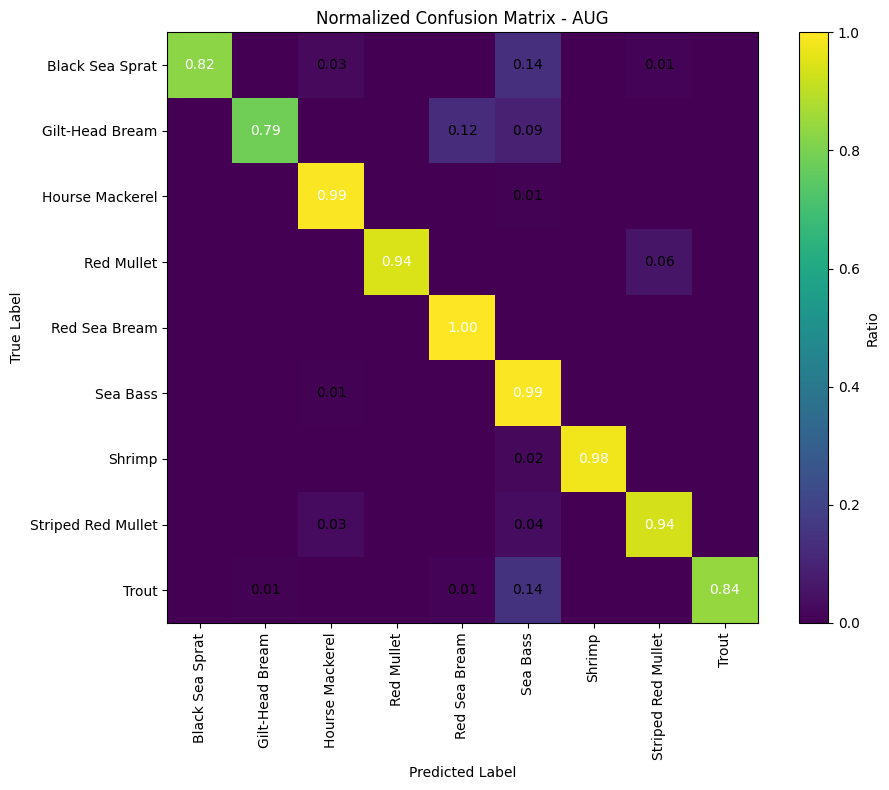

In [29]:
import matplotlib.pyplot as plt

cm_aug_norm = cm_aug.astype("float") / cm_aug.sum(axis=1, keepdims=True)

plt.figure(figsize=(10,8))
plt.imshow(cm_aug_norm, vmin=0, vmax=1)
plt.title("Normalized Confusion Matrix - AUG")
plt.colorbar(label="Ratio")

plt.xticks(range(len(classes)), classes, rotation=90)
plt.yticks(range(len(classes)), classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

for i in range(len(classes)):
    for j in range(len(classes)):
        value = cm_aug_norm[i, j]
        if value > 0:
            plt.text(j, i, f"{value:.2f}",
                     ha="center", va="center",
                     color="white" if value > 0.5 else "black")

plt.tight_layout()
plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

test_gen_no = ImageDataGenerator(preprocessing_function=preprocess)

test_data_no = test_gen_no.flow_from_dataframe(
    test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    classes=classes,          # aşağıda classes konusunu da düzelteceğiz
    class_mode="categorical",
    batch_size=4,
    shuffle=False
)


Found 1800 validated image filenames belonging to 9 classes.


In [12]:
model_no = load_model("outputs/20260102_191146/no_aug/model/best_model.keras")
y_pred = np.argmax(model_no.predict(test_data_no), axis=1)
y_true = test_data_no.classes

idx2label = {v:k for k,v in test_data_no.class_indices.items()}
target_names = [idx2label[i] for i in range(len(idx2label))]

print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))


450/450 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       200
   Gilt-Head Bream       1.00      0.99      1.00       200
   Hourse Mackerel       1.00      1.00      1.00       200
        Red Mullet       1.00      1.00      1.00       200
     Red Sea Bream       1.00      1.00      1.00       200
          Sea Bass       1.00      1.00      1.00       200
            Shrimp       1.00      1.00      1.00       200
Striped Red Mullet       1.00      1.00      1.00       200
             Trout       1.00      1.00      1.00       200

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



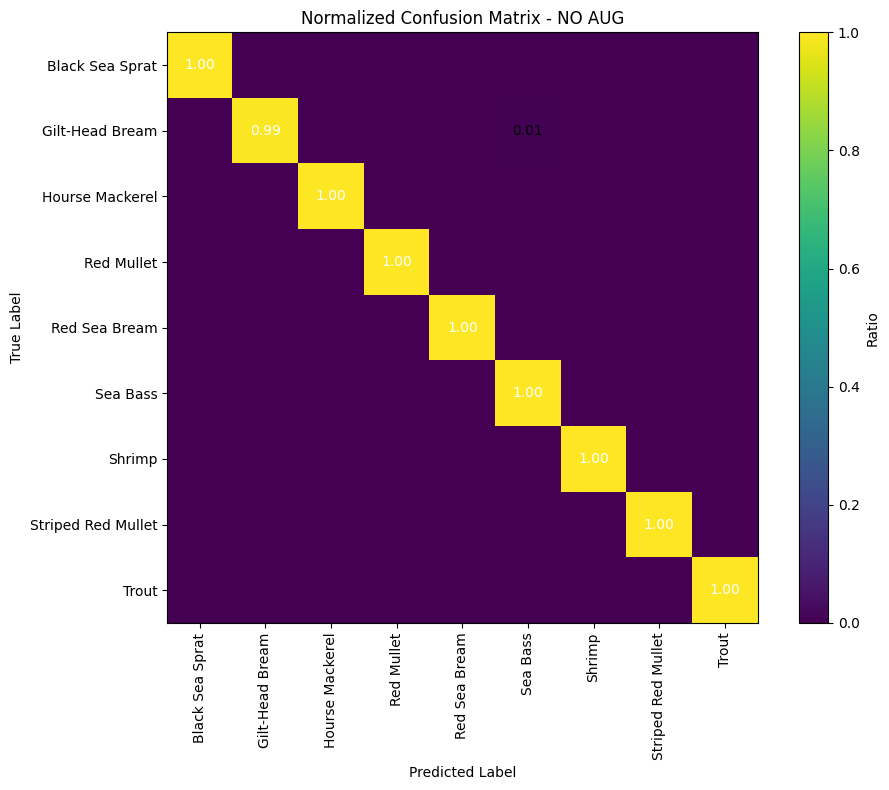

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Normalize edilmiş confusion matrix
cm_no_norm = cm_no.astype("float") / cm_no.sum(axis=1, keepdims=True)

plt.figure(figsize=(10,8))
plt.imshow(cm_no_norm, vmin=0, vmax=1)
plt.title("Normalized Confusion Matrix - NO AUG")
plt.colorbar(label="Ratio")

plt.xticks(range(len(classes)), classes, rotation=90)
plt.yticks(range(len(classes)), classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Hücre içine değer yaz
for i in range(len(classes)):
    for j in range(len(classes)):
        value = cm_no_norm[i, j]
        if value > 0:
            plt.text(j, i, f"{value:.2f}",
                     ha="center", va="center",
                     color="white" if value > 0.5 else "black")

plt.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import train_test_split

SEED = 42

trainval_df, test_df = train_test_split(
    image_df,
    test_size=0.2,
    stratify=image_df["Label"],
    random_state=SEED
)

train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    stratify=trainval_df["Label"],
    random_state=SEED
)


In [15]:
leak = set(train_df["Filepath"]).intersection(set(test_df["Filepath"]))

print("Sızıntı var mı?", len(leak) > 0)
print("Ortak dosya sayısı:", len(leak))


Sızıntı var mı? False
Ortak dosya sayısı: 0
